# 📘 Machine Learning 2025/2026  

## Laboratorio 4.1 — Regressione Lineare, Gradient Descent e Regolarizzazione  
## Docenti: Danilo Croce, Giorgio Gambosi  

In questo laboratorio esploriamo **l’intero percorso della regressione lineare**, partendo dalle basi fino alle versioni regolarizzate (*Ridge* e *Lasso*), passando attraverso la **discesa del gradiente**.  

L’obiettivo è stimare una funzione non lineare (una sinusoide) a partire da pochi punti **rumorosi**, e comprendere come la complessità del modello e la regolarizzazione influenzino il risultato.

---

## 🎯 Obiettivi didattici

1. **Comprendere la regressione lineare come modello base** di apprendimento supervisionato.  
2. **Costruire la matrice di design polinomiale** per trasformare un problema non lineare in uno lineare nei parametri.  
3. **Derivare e implementare la soluzione analitica** ai minimi quadrati:
   $$
   w^* = (\Phi^\top \Phi)^{-1} \Phi^\top t.
   $$
4. **Implementare la discesa del gradiente (Gradient Descent)** e confrontarla con la soluzione chiusa.  
5. **Osservare il trade-off bias–varianza** al variare del grado polinomiale $M$.  
6. **Introdurre la regolarizzazione L2 (Ridge)** e L1 (Lasso) per evitare overfitting e ottenere modelli più stabili.  

---

## 📚 Struttura del notebook

| Sezione | Contenuto |
|----------|------------|
| **1. Setup e dataset** | Generazione dei dati rumorosi da una sinusoide. |
| **2. Matrice di design polinomiale** | Costruzione della base $[1, x, x^2, …, x^M]$. |
| **3. Regressione ai minimi quadrati (forma chiusa)** | Derivazione e implementazione della soluzione analitica. |
| **4. Gradient Descent** | Approccio iterativo alla minimizzazione del costo. |
| **5. Ridge Regression** | Regolarizzazione L2 — soluzione analitica e iterativa. |
| **6. Lasso Regression** | Regolarizzazione L1 e confronto qualitativo. |
| **7. Regressione con scikit-learn** | Mostriamo come utilizzare la libreria `scikit-learn` per implementare in modo semplice le stesse tecniche  |
---

### 🧩 Setup e Dataset

In questa prima sezione costruiamo il **dataset sintetico** su cui lavoreremo per tutto il laboratorio.

Simuliamo un esperimento di regressione in cui i dati sono generati da una **funzione sinusoidale**:

$$
t = \sin(2\pi x) + \varepsilon, \quad \varepsilon \sim \mathscr{N}(0, \sigma^2),
$$

dove $ \varepsilon $ rappresenta un **rumore gaussiano** che introduce incertezza nelle osservazioni.  

---

### 🎯 Obiettivo

Il nostro scopo è ricostruire la funzione sottostante (la sinusoide “vera”) partendo da pochi punti rumorosi, analizzando:

1. **Come la complessità del modello** (grado polinomiale $M$) influisce sulla qualità del fit.  
2. **Come diversi metodi di ottimizzazione** — forma chiusa, *gradient descent*, e regolarizzazioni (*Ridge* e *Lasso*) — modificano la soluzione.  
3. **Come la normalizzazione dei dati** aiuta la stabilità numerica.

---

### ⚙️ Cosa fa il codice seguente

- Genera un piccolo **training set** (15 punti) rumoroso.  
- Crea un **test set denso** per visualizzare la funzione continua.  
- Aggiunge rumore gaussiano per simulare misure reali.  
- Normalizza le feature per evitare instabilità nei calcoli.  
- Visualizza graficamente i punti campionati rispetto alla funzione vera $ \sin(2\pi x) $.

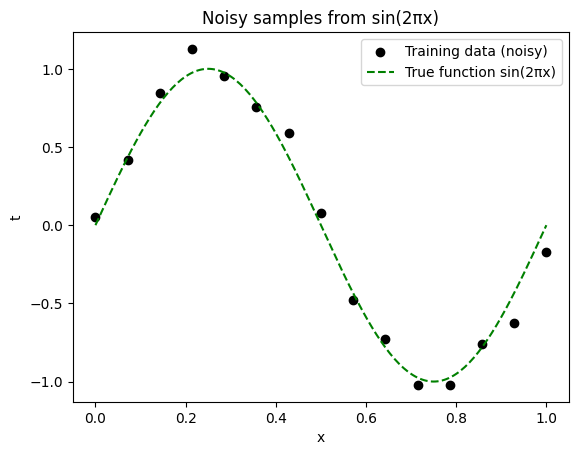

In [ ]:
# %%
# ============================================================
# LINEAR REGRESSION on a noisy sine function
# From least squares → gradient descent → ridge → lasso
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

# Impostiamo il seed per rendere i risultati riproducibili
np.random.seed(42)

# ------------------------------------------------------------
# 1️⃣  Generazione del dataset
# ------------------------------------------------------------

# Numero di punti nel training set (pochi, per rendere il problema ambiguo)
n_train = 15

# Numero di punti per il test (molti, per valutare il modello su tutto l'intervallo)
n_test = 200

# Deviazione standard del rumore gaussiano
sigma = 0.1

# Punti di training equispaziati tra 0 e 1
X_train = np.linspace(0, 1, n_train).reshape(-1, 1)

# Funzione di verità: sin(2πx)
# Aggiungiamo un rumore gaussiano ~ N(0, σ²)
# → simula dati sperimentali "realistici" (non perfettamente puliti)
t_train = np.sin(2 * np.pi * X_train) + np.random.normal(0, sigma, X_train.shape)

# Dataset di test molto più denso (per visualizzare la curva continua)
X_test = np.linspace(0, 1, n_test).reshape(-1, 1)
t_test = np.sin(2 * np.pi * X_test)  # senza rumore → funzione "vera"

# ------------------------------------------------------------
# 2️⃣  Normalizzazione delle feature
# ------------------------------------------------------------

# Centriamo e scaliamo X per evitare problemi di overflow/underflow
# (soprattutto per polinomi di grado elevato)
X_mean, X_std = np.mean(X_train), np.std(X_train)
X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std

# ------------------------------------------------------------
# 3️⃣  Visualizzazione dei dati
# ------------------------------------------------------------

plt.scatter(X_train, t_train, color="black", label="Training data (noisy)")
plt.plot(X_test, t_test, "g--", label="True function sin(2πx)")
plt.legend()
plt.title("Noisy samples from sin(2πx)")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

## 🧮 Matrice delle feature polinomiali

Per poter applicare la regressione lineare a un problema *non lineare* (come la nostra sinusoide),  
costruiamo una **base polinomiale** dei dati di input.

Ogni punto $x_i$ viene trasformato in un vettore di potenze:

$$
\phi(x_i) = [\,1,\, x_i,\, x_i^2,\, \dots,\, x_i^M\,],
$$

dove $M$ è il **grado del polinomio** scelto.

Raggruppando tutte le $n$ osservazioni otteniamo la **matrice di progetto** (*design matrix*):

$$
\Phi =
\begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^M \\
1 & x_2 & x_2^2 & \cdots & x_2^M \\
\vdots & \vdots & \vdots & & \vdots \\
1 & x_n & x_n^2 & \cdots & x_n^M
\end{bmatrix}
\in \mathbb{R}^{n\times (M+1)}.
$$

Ogni colonna rappresenta un “livello di complessità” del modello:
- la prima (tutta 1) serve per il **bias** $b$;
- le successive corrispondono ai termini $x$, $x^2$, $\dots$, $x^M$.

In Python, questa costruzione può essere fatta comodamente con `np.hstack`:

In [ ]:
# %%
def polynomial_design_matrix(X, M):
    """Ritorna la matrice delle feature [1, x, x^2, ..., x^M]."""
    return np.hstack([X**i for i in range(M + 1)])

## 🎯 Regressione ai Minimi Quadrati — Soluzione Analitica

Una volta costruita la matrice delle feature $\Phi$,  
il modello polinomiale diventa **lineare nei parametri**:

$$
y = \Phi w,
$$

dove:
- $\Phi \in \mathbb{R}^{n\times (M+1)}$ è la *design matrix* (ogni riga è $\phi(x_i)$),
- $w \in \mathbb{R}^{M+1}$ contiene il bias e i coefficienti polinomiali,
- $t \in \mathbb{R}^{n}$ rappresenta i valori target osservati.

---

### 🔹 Funzione di costo (Errore Quadratico Medio)

Definiamo il costo come **media dei quadrati dei residui**:

$$
E(w) = \frac{1}{2n}\|\Phi w - t\|^2
= \frac{1}{2n}(\Phi w - t)^\top(\Phi w - t),
$$

dove il fattore $\tfrac{1}{2n}$ è solo una convenzione utile per semplificare le derivate.

---

### 🔹 Derivata rispetto ai pesi

Richiamiamo la regola generale:

$$
\nabla_u\,\frac{1}{2}\|A u - b\|^2 = A^\top(Au - b).
$$

Applicandola con $A=\Phi$, $u=w$ e $b=t$, otteniamo:

$$
\nabla_w E(w) = \frac{1}{n}\,\Phi^\top(\Phi w - t).
$$

---

### 🔹 Condizione di minimo

Per trovare il punto stazionario imponiamo che il gradiente sia nullo:

$$
\nabla_w E(w) = 0
\quad \Longrightarrow \quad
\Phi^\top(\Phi w - t) = 0.
$$

Da cui segue:

$$
\Phi^\top \Phi w = \Phi^\top t.
$$

Questa è la **forma normale** (*normal equation*), un sistema lineare in $w$.

---

### 🔹 Soluzione in forma chiusa

Se $\Phi^\top\Phi$ è invertibile (colonne linearmente indipendenti),  
la soluzione ottimale è:

$$
\boxed{w^\ast = (\Phi^\top\Phi)^{-1}\Phi^\top t.}
$$

Se invece $\Phi^\top\Phi$ è singolare (ad esempio quando $M+1 > n$),  
si utilizza la **pseudoinversa di Moore–Penrose**:

$$
w^\ast = \Phi^{+}t.
$$

---

### 🔹 Interpretazione

- $\Phi^\top\Phi$ rappresenta la **correlazione** tra le colonne (feature).  
- $\Phi^\top t$ è la **proiezione dei target** sullo spazio generato dalle feature.  
- L’equazione $(\Phi^\top\Phi)w=\Phi^\top t$ individua il vettore $w$ che  
  **minimizza la somma dei quadrati degli errori** tra le predizioni $\Phi w$ e i valori reali $t$.

---

📘 In sintesi: la regressione ai minimi quadrati trova la retta (o curva polinomiale)  
che approssima al meglio i dati nel senso dei minimi quadrati, fornendo una soluzione chiusa e diretta al problema di apprendimento.

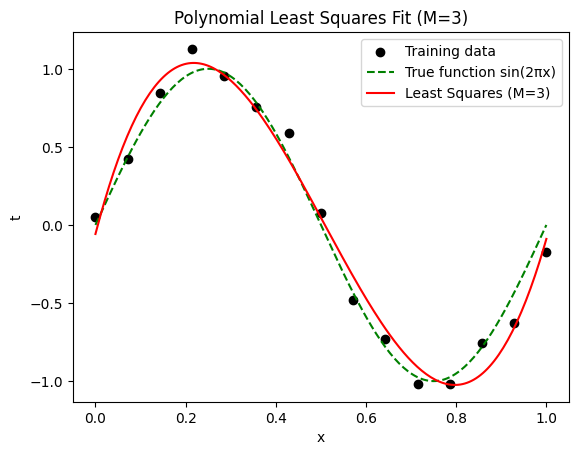

In [ ]:
# %%
# ============================================================
# POLYNOMIAL LEAST SQUARES FIT
# ============================================================

def fit_least_squares(X, t, M):
    """
    Calcola i pesi ottimali w per la regressione ai minimi quadrati
    con base polinomiale di grado M.

    Parametri:
        X : array di input normalizzato (n x 1)
        t : target (n x 1)
        M : grado del polinomio
    Ritorna:
        w : pesi stimati (vettore di lunghezza M+1)
        Phi : matrice di design (n x M+1)
    """
    Phi = polynomial_design_matrix(X, M)              # costruisce [1, x, x^2, ..., x^M]
    w = np.linalg.pinv(Phi.T @ Phi) @ Phi.T @ t       # soluzione in forma chiusa: w = (ΦᵀΦ)^(-1) Φᵀ t
    return w, Phi


def predict(X, w):
    """
    Genera le predizioni y = Φ w dato un vettore di pesi w
    e un insieme di punti X (normalizzati).
    """
    Phi = polynomial_design_matrix(X, len(w) - 1)
    return Phi @ w


# ------------------------------------------------------------
# 1️⃣  Esempio singolo: M = 3
# ------------------------------------------------------------

M = 3
w_ls, Phi_train = fit_least_squares(X_train_n, t_train, M)
y_ls = predict(X_test_n, w_ls)

plt.scatter(X_train, t_train, color="black", label="Training data")
plt.plot(X_test, t_test, "g--", label="True function sin(2πx)")
plt.plot(X_test, y_ls, "r", label=f"Least Squares (M={M})")
plt.legend()
plt.title("Polynomial Least Squares Fit (M=3)")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

### 🔍 Polynomial Fits for Multiple Degrees $ M $

In questa sezione osserviamo **come cambia la complessità del modello** aumentando il grado polinomiale $ M $ nella regressione ai minimi quadrati.

Partendo da pochi punti rumorosi generati da $ \sin(2\pi x) $, costruiamo modelli polinomiali di gradi diversi e confrontiamo le curve risultanti:

$$
y(x) = \sum_{j=0}^{M} w_j x^j = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M
$$

Per ciascun $ M $:

1. Costruiamo la **matrice di design** $ \Phi = [1, x, x^2, \dots, x^M] $.
2. Calcoliamo i pesi ottimali $ w = (\Phi^\top \Phi)^{-1} \Phi^\top t $.
3. Visualizziamo la curva ottenuta insieme ai dati e alla funzione vera.

---


=== Mean Squared Error (MSE) ===
Grado M	Train MSE	Test MSE
----------------------------------
0      	0.52298	0.49750
1      	0.24113	0.20179
3      	0.01116	0.01200
5      	0.00416	0.00385
9      	0.00242	0.00751
12     	0.00048	0.03391


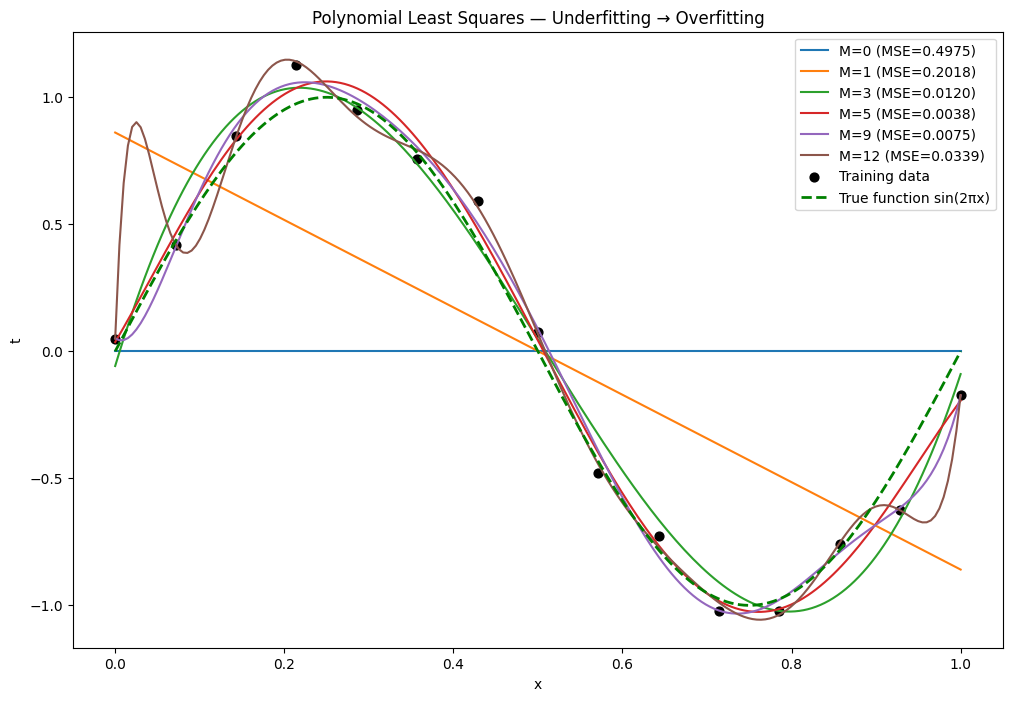

In [ ]:
# %%
# ============================================================
# 2️⃣  POLYNOMIAL FITS FOR MULTIPLE DEGREES M + MSE
# ============================================================

from sklearn.metrics import mean_squared_error

degrees = [0, 1, 3, 5, 9, 12]  # diversi gradi di complessità

plt.figure(figsize=(12, 8))

print("=== Mean Squared Error (MSE) ===")
print("Grado M\tTrain MSE\tTest MSE")
print("----------------------------------")

for M in degrees:
    # Fit del modello ai minimi quadrati
    w_ls, Phi_train = fit_least_squares(X_train_n, t_train, M)

    # Predizioni su train e test
    y_train_pred = predict(X_train_n, w_ls)
    y_test_pred  = predict(X_test_n, w_ls)

    # Calcolo MSE
    mse_train = mean_squared_error(t_train, y_train_pred)
    mse_test  = mean_squared_error(t_test, y_test_pred)

    # Stampa tabellina dei risultati
    print(f"{M:<7d}\t{mse_train:.5f}\t{mse_test:.5f}")

    # Tracciamento del modello
    plt.plot(X_test, y_test_pred, label=f"M={M} (MSE={mse_test:.4f})")

# Dati e funzione vera
plt.scatter(X_train, t_train, color="black", s=40, label="Training data")
plt.plot(X_test, t_test, "g--", linewidth=2, label="True function sin(2πx)")

plt.legend()
plt.title("Polynomial Least Squares — Underfitting → Overfitting")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

#### 💡 Cosa osservare nel grafico

- **Basso grado (M = 0, 1)** →  
  La curva è troppo semplice: non riesce a seguire la forma sinusoidale.  
  → **Underfitting**: alto bias, errore sistematico.

- **Grado medio (M = 3–5)** →  
  Il modello segue bene l’andamento della sinusoide senza oscillare.  
  → Buon compromesso bias–varianza.

- **Grado alto (M ≥ 9)** →  
  Il modello “passa per tutti i punti di training”, ma oscilla violentemente tra di essi.  
  → **Overfitting**: bassa capacità di generalizzare.

---

#### 📈 Conclusione

Aumentare $ M $ fa crescere la **flessibilità del modello**, ma anche la **varianza** delle previsioni.  
Con pochi dati e rumore, gradi troppo alti portano a curve irrealistiche: il modello impara anche il rumore invece del segnale.

Questo esperimento visualizza in modo chiaro il **trade-off bias–varianza**, cuore di tutti i problemi di apprendimento automatico.

---

## ⚙️ Polynomial Regression — Gradient Descent Implementation

Finora abbiamo risolto la regressione polinomiale **in forma chiusa**, con la classica soluzione ai minimi quadrati:

$$
w^\ast = (\Phi^\top \Phi)^{-1} \Phi^\top t.
$$

Ora affrontiamo lo stesso problema **in modo iterativo**, usando la **Discesa del Gradiente (Gradient Descent)**,  
che aggiorna progressivamente i parametri per ridurre l’errore.

---

### 🔹 1️⃣ Funzione di costo

Definiamo la funzione di costo come l’**errore quadratico medio (MSE)**:

$$
E(w) = \frac{1}{2n} \|\Phi w - t\|^2
     = \frac{1}{2n}(\Phi w - t)^\top(\Phi w - t).
$$

Il fattore $\tfrac{1}{2n}$ è solo una costante di normalizzazione utile per semplificare le derivate.

---

### 🔹 2️⃣ Gradiente rispetto a $w$

Calcoliamo il gradiente $\nabla_w E(w)$.

- Derivando il termine quadratico otteniamo:  
  $$\nabla_w \frac{1}{2n} w^\top \Phi^\top \Phi w = \frac{1}{n}\Phi^\top \Phi w.$$

- Il termine misto:  
  $$\nabla_w \left(-\frac{1}{n} t^\top \Phi w \right) = -\frac{1}{n}\Phi^\top t.$$

- Il termine $t^\top t$ non dipende da $w$ → derivata nulla.

Combinando tutto:
$$
\nabla_w E(w) = \frac{1}{n}\Phi^\top(\Phi w - t).
$$

---

### 🔹 3️⃣ Aggiornamento iterativo

Ad ogni passo $k$:

$$
w^{(k+1)} = w^{(k)} - \eta \, \nabla_w E(w^{(k)}),
$$

ossia:

$$
w^{(k+1)} = w^{(k)} - \frac{\eta}{n}\Phi^\top(\Phi w^{(k)} - t),
$$

dove $\eta$ è il **learning rate**, cioè la dimensione del passo di aggiornamento.

---

### 🔹 4️⃣ Interpretazione intuitiva

- $(\Phi w - t)$ è il vettore dei **residui** (gli errori di predizione).  
- $\Phi^\top(\Phi w - t)$ calcola quanto questi errori sono **correlati con ciascuna feature**.  
- Aggiornando $w$ nella direzione opposta, il modello “raddrizza” progressivamente la previsione finché il gradiente si annulla.

---

### 🔹 5️⃣ Convergenza e minimo

Quando il gradiente diventa nullo:

$$
\nabla_w E(w^\ast) = 0
\;\;\Rightarrow\;\;
\Phi^\top(\Phi w^\ast - t) = 0,
$$

che è **esattamente** la condizione dei **minimi quadrati**:

$$
(\Phi^\top \Phi)w^\ast = \Phi^\top t.
$$

---

### 🔹 6️⃣ Considerazioni pratiche

| Caso | Effetto |
|------|----------|
| $\eta$ troppo grande | Il costo oscilla o diverge |
| $\eta$ troppo piccolo | Converge molto lentamente |
| Valore ideale | Diminuzione rapida ma stabile di $E(w)$ |

Il grafico “**Costo vs Iterazione**” mostra tipicamente una discesa rapida iniziale, poi un plateau vicino al minimo.

---

### 💡 In sintesi

| Concetto | Formula | Significato |
|-----------|----------|-------------|
| Funzione di costo | $${E(w) = \tfrac{1}{2n}\|\Phi w - t\|^2}$$ | Errore medio quadratico |
| Gradiente | $$\nabla_w E(w) = \tfrac{1}{n}\Phi^\top(\Phi w - t)$$ | Direzione di massima crescita |
| Aggiornamento | $$w \leftarrow w - \eta \nabla_w E(w)$$ | Passo verso il minimo |
| Condizione di minimo | $$\Phi^\top(\Phi w^\ast - t)=0$$ | Coincide con la soluzione ai minimi quadrati |

---

### 🔹 7️⃣ Collegamento al codice

Nel notebook, implementiamo:
- `cost()` → calcola $E(w)$  
- `grad()` → calcola $\nabla_w E(w)$  
- `gradient_descent()` → aggiorna $w$ iterativamente  

Alla fine, $w$ converge alla stessa soluzione analitica,  
ma ottenuta **tramite aggiornamenti incrementali**, come nei moderni algoritmi di *deep learning*.

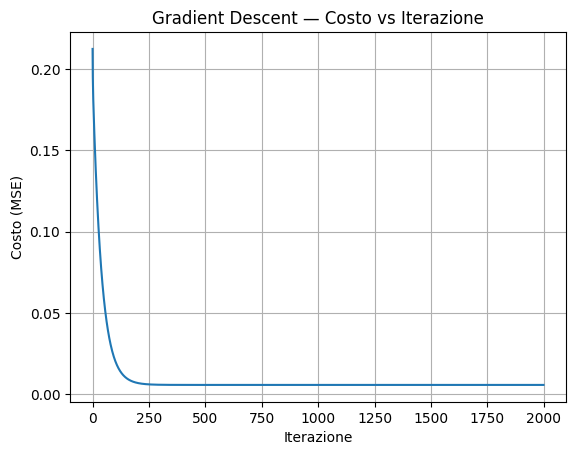

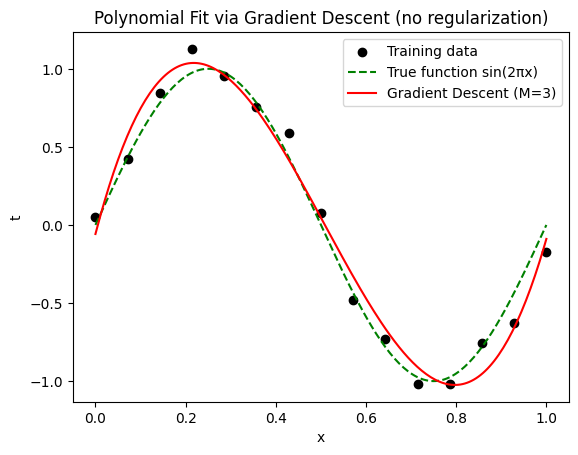

In [ ]:
# %%
# ============================================================
# POLYNOMIAL REGRESSION — GRADIENT DESCENT (BATCH FORM)
# ============================================================
# Obiettivo:
#   Approssimare una funzione (sinusoidale) usando regressione polinomiale
#   con ottimizzazione iterativa tramite discesa del gradiente.
#
#   In questa versione il gradiente è calcolato su TUTTO il dataset
#   → "Batch Gradient Descent".
#   Le versioni "Stochastic" e "Mini-Batch" sono varianti che usano
#   rispettivamente un solo campione o un sottoinsieme a ogni passo.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1️⃣  Funzione di costo (Mean Squared Error)
# ------------------------------------------------------------
def cost(Phi, w, t):
    """
    Calcola la funzione di costo:
        E(w) = 1/(2n) * ||Φw - t||²
    dove:
        Φ : matrice di design (n × M+1)
        w : vettore dei pesi (M+1 × 1)
        t : target (n × 1)
    """
    r = Phi @ w - t        # residui = differenza tra predizioni e valori reali
    return 0.5 * np.mean(r**2)


# ------------------------------------------------------------
# 2️⃣  Gradiente della funzione di costo
# ------------------------------------------------------------
def grad(Phi, w, t):
    """
    Calcola il gradiente del costo rispetto ai pesi:
        ∇E(w) = (1/n) * Φᵀ(Φw - t)
    che indica la direzione di massima crescita del costo.
    """
    r = Phi @ w - t
    return (Phi.T @ r) / len(t)


# ------------------------------------------------------------
# 3️⃣  Discesa del gradiente (Batch)
# ------------------------------------------------------------
def gradient_descent(Phi, t, eta=1e-2, epochs=5000):
    """
    Esegue la discesa del gradiente batch:
        w ← w - η ∇E(w)
    fino alla convergenza o per un numero prefissato di iterazioni.

    Parametri:
        Phi    : matrice di design (n × M+1)
        t      : vettore target (n × 1)
        eta    : learning rate (controlla l’ampiezza del passo)
        epochs : numero di iterazioni di aggiornamento

    Ritorna:
        w      : pesi appresi
        costs  : lista dei valori di E(w) nel tempo
    """
    # Inizializzazione dei pesi (tutti a zero)
    w = np.zeros((Phi.shape[1], 1))
    costs = []

    # Ciclo di ottimizzazione
    for _ in range(epochs):
        # Calcolo del gradiente completo (su tutti i dati)
        g = grad(Phi, w, t)
        # Aggiornamento dei pesi
        w -= eta * g
        # Calcolo e memorizzazione del costo corrente
        costs.append(cost(Phi, w, t))

    return w, costs


# ------------------------------------------------------------
# 4️⃣  Applicazione: POLINOMIO DI GRADO M = 3
# ------------------------------------------------------------
M = 3
Phi_train = polynomial_design_matrix(X_train_n, M)

# Applichiamo la discesa del gradiente
# η = 0.1 → learning rate moderato
# epochs = 2000 → iterazioni sufficienti per convergere
w_gd, costs = gradient_descent(Phi_train, t_train, eta=0.1, epochs=2000)

# Predizioni sul test set
y_gd = predict(X_test_n, w_gd)


# ------------------------------------------------------------
# 5️⃣  Analisi della convergenza
# ------------------------------------------------------------
plt.plot(costs)
plt.title("Gradient Descent — Costo vs Iterazione")
plt.xlabel("Iterazione")
plt.ylabel("Costo (MSE)")
plt.grid(True)
plt.show()


# ------------------------------------------------------------
# 6️⃣  Confronto con la funzione vera
# ------------------------------------------------------------
plt.scatter(X_train, t_train, color="black", label="Training data")
plt.plot(X_test, t_test, "g--", label="True function sin(2πx)")
plt.plot(X_test, y_gd, "r", label=f"Gradient Descent (M={M})")
plt.legend()
plt.title("Polynomial Fit via Gradient Descent (no regularization)")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


# ------------------------------------------------------------
# 🔸 NOTA: VARIANTI DEL GRADIENTE 🔸
# ------------------------------------------------------------
# - BATCH GRADIENT DESCENT:
#     Usa TUTTO il dataset per calcolare ∇E(w) a ogni passo.
#     → Aggiornamento preciso ma costoso (1 passo per epoca).
#
# - STOCHASTIC GRADIENT DESCENT (SGD):
#     Usa UN SOLO campione (x_i, t_i) per calcolare il gradiente:
#         g_i = (Φ_iᵀ(Φ_i w - t_i))
#     → Aggiornamento molto frequente, ma rumoroso.
#
# - MINI-BATCH GRADIENT DESCENT:
#     Usa un sottoinsieme casuale B ⊂ {1,…,n}:
#         g_B = (1/|B|) Φ_Bᵀ(Φ_B w - t_B)
#     → Compromesso tra stabilità (batch) e velocità (SGD).
#
# Queste versioni si implementano modificando la riga:
#     g = grad(Phi, w, t)
# sostituendola con il calcolo del gradiente su un sottoinsieme.

### ⚠️ Nota sui gradi polinomiali elevati

Nel codice abbiamo limitato i gradi polinomiali a $M \le 7$,  
evitando valori più alti (come $M=9$ o $M=12$) per motivi di **stabilità numerica**.

Infatti, la matrice di design

$$
\Phi = [1, x, x^2, \dots, x^M]
$$

contiene potenze crescenti di $x$, e quando $x$ non è perfettamente centrato o normalizzato,  
i termini $x^M$ possono diventare **molto grandi** o **molto piccoli** (overflow o underflow numerico).

Questo comporta:
- una **condizionatura molto alta** della matrice $\Phi^\top \Phi$,  
  che rende l’apprendimento instabile;
- una propagazione degli errori di arrotondamento in `float64`;
- gradienti che diventano enormi o NaN durante l’ottimizzazione.

Per questo motivo, nei test sperimentali abbiamo scelto gradi moderati  
($M = 0, 1, 3, 5, 7$), che permettono di osservare il fenomeno  
di *underfitting → overfitting* senza incorrere in problemi di rappresentazione numerica.

---

## 🚀 Polynomial Regression con Gradient Descent

Applichiamo la **discesa del gradiente** per stimare i parametri $w$ di modelli polinomiali di diverso grado $M$.  
Per ciascun $M$:
- costruiamo la matrice di design $\Phi = [1, x, x^2, …, x^M]$  
- aggiorniamo i pesi iterativamente $w \leftarrow w - \eta \nabla_w E(w)$  
- tracciamo la curva appresa e l’andamento del costo $E(w)$.

In questo modo osserviamo come la complessità del modello e il learning rate influenzano  
la **convergenza** e il **rischio di overfitting**.

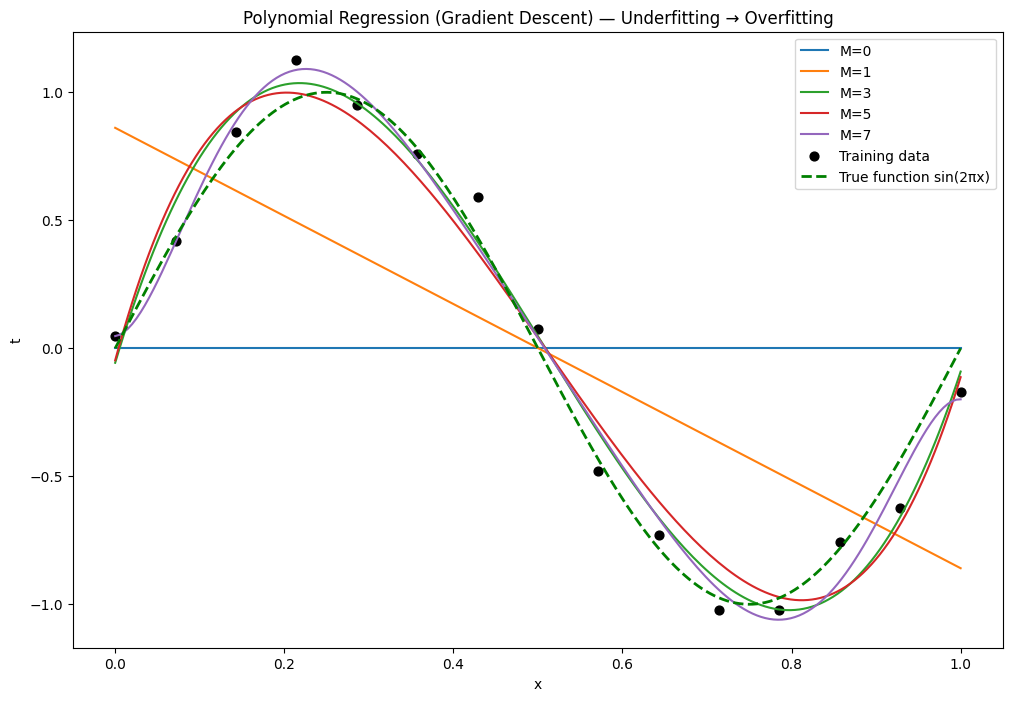

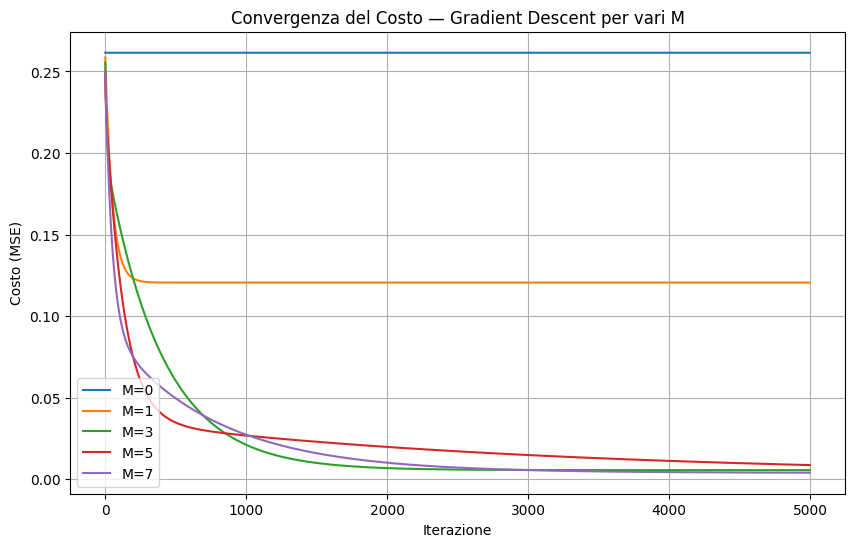

In [ ]:
# %%
# ============================================================
# 3️⃣  POLYNOMIAL FITS (GRADIENT DESCENT VERSION)
# ============================================================
# Per ogni grado M:
#   - costruiamo la matrice di design Φ
#   - addestriamo il modello con discesa del gradiente
#   - salviamo l'andamento del costo
#   - visualizziamo le curve apprese
# ============================================================

degrees = [0, 1, 3, 5, 7]      # diversi gradi di complessità
eta = 0.01                          # learning rate moderato
epochs = 5000                     # numero di iterazioni

plt.figure(figsize=(12, 8))

loss_histories = {}  # per tracciare i costi durante l'addestramento

# ------------------------------------------------------------
# Ciclo sui diversi gradi polinomiali
# ------------------------------------------------------------
for M in degrees:
    # Costruzione della matrice di design
    Phi_train = polynomial_design_matrix(X_train_n, M)

    # Addestramento tramite discesa del gradiente
    w_gd, costs = gradient_descent(Phi_train, t_train, eta=eta, epochs=epochs)

    # Predizioni sul test set
    y_gd = predict(X_test_n, w_gd)

    # Tracciamo la curva appresa
    plt.plot(X_test, y_gd, label=f"M={M}")

    # Salviamo la loss
    loss_histories[M] = costs

# ------------------------------------------------------------
# Dati e funzione vera
# ------------------------------------------------------------
plt.scatter(X_train, t_train, color="black", s=40, label="Training data")
plt.plot(X_test, t_test, "g--", linewidth=2, label="True function sin(2πx)")

plt.legend()
plt.title("Polynomial Regression (Gradient Descent) — Underfitting → Overfitting")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


# ------------------------------------------------------------
# 4️⃣  Andamento della funzione di costo per ogni grado M
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for M, costs in loss_histories.items():
    plt.plot(costs, label=f"M={M}")
plt.title("Convergenza del Costo — Gradient Descent per vari M")
plt.xlabel("Iterazione")
plt.ylabel("Costo (MSE)")
plt.legend()
plt.grid(True)
plt.show()

---

## ⚙️ Ridge Regression — Soluzione in forma chiusa

La **Ridge Regression** (o **Least Squares regolarizzata**) è un’estensione della regressione lineare classica, pensata per:

1. **Evitare l’overfitting**, specialmente quando il grado del polinomio $M$ è alto.  
2. **Gestire problemi di multicollinearità** (colonne di $\Phi$ quasi dipendenti).  
3. **Stabilizzare la matrice** $(\Phi^\top \Phi)$, rendendola invertibile.

---

### 🔹 1️⃣ Funzione di costo con regolarizzazione L2

A differenza dei minimi quadrati standard, aggiungiamo una penalizzazione sulla norma dei pesi:

$$
E_\lambda(w) = \frac{1}{2n} \| \Phi w - t \|^2 + \frac{\lambda}{2} \| w \|^2
$$

dove:

- $\Phi$ è la matrice di design $(n \times (M+1))$,  
- $w$ è il vettore dei coefficienti,  
- $\lambda > 0$ è il **fattore di regolarizzazione**.  

> Il secondo termine spinge i pesi $w$ a rimanere piccoli, riducendo la complessità del modello.

---

### 🔹 2️⃣ Derivazione del gradiente

Partiamo dal costo:

$$
E_\lambda(w) = \frac{1}{2n}(\Phi w - t)^\top(\Phi w - t) + \frac{\lambda}{2} w^\top w.
$$

Calcoliamo la derivata rispetto a $w$:

$$
\begin{aligned}
\nabla_w E_\lambda(w)
&= \frac{1}{n}\Phi^\top(\Phi w - t) + \lambda w.
\end{aligned}
$$

---

### 🔹 3️⃣ Condizione di minimo

Al minimo, il gradiente è nullo:

$$
\nabla_w E_\lambda(w^\ast) = 0
\quad \Rightarrow \quad
\frac{1}{n}\Phi^\top(\Phi w^\ast - t) + \lambda w^\ast = 0.
$$

Moltiplichiamo per $n$ e riordiniamo:

$$
(\Phi^\top \Phi + n\lambda I) w^\ast = \Phi^\top t.
$$

> In molti testi (come Bishop o Hastie), $\lambda$ viene ridefinito assorbendo il fattore $n$:
>
> $$
> (\Phi^\top \Phi + \lambda I) w^\ast = \Phi^\top t.
> $$

Questa è la **forma chiusa della Ridge Regression**.

---

### 🔹 4️⃣ Soluzione analitica

Risolvendo il sistema lineare otteniamo:

$$
\boxed{
w^\ast = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top t.
}
$$

- Se $\lambda = 0$, si torna ai **minimi quadrati ordinari**.  
- Se $\lambda > 0$, la matrice da invertire è **sempre ben condizionata** (invertibile anche in caso di collinearità).  
- $\lambda$ controlla il *trade-off* bias–varianza:
  - $\lambda$ grande → pesi piccoli, modello rigido (più bias, meno varianza);  
  - $\lambda$ piccolo → modello flessibile, più rischio di overfitting.

---

### 🔹 5️⃣ Interpretazione geometrica

L’aggiunta del termine $\lambda \|w\|^2$ può essere vista come una **penalizzazione**:

- senza regolarizzazione, i pesi $w$ possono crescere molto per adattarsi ai punti rumorosi;  
- con regolarizzazione, il modello è “tirato” verso la soluzione più semplice (pesi piccoli).

---

### 🔹 6️⃣ Effetto pratico nel codice

Nel codice, la riga chiave:

$$
w = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top t
$$

implementa esattamente questa formula.

- `I` è la matrice identità $(M+1) \times (M+1)$,  
- il termine `lam * I` regolarizza la diagonale,  
- `np.linalg.pinv()` assicura stabilità numerica anche se la matrice non è perfettamente invertibile.

---

### 💡 In sintesi

| Concetto | Formula | Effetto |
|-----------|----------|---------|
| Funzione di costo | $E_\lambda(w) = \frac{1}{2n}\|\Phi w - t\|^2 + \frac{\lambda}{2}\|w\|^2$ | penalizza pesi grandi |
| Gradiente | $\nabla_w E_\lambda(w) = \frac{1}{n}\Phi^\top(\Phi w - t) + \lambda w$ | aggiunge “forza di richiamo” |
| Equazione normale | $$(\Phi^\top \Phi + \lambda I)w = \Phi^\top t$$ | sistema lineare regolarizzato |
| Soluzione chiusa | $$w^\ast = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top t$$ | sempre invertibile |
| Effetto di $\lambda$ | ↑ stabilità, ↓ varianza, ↑ bias | controlla la complessità |

---

In pratica, **Ridge Regression** è una versione più robusta dei minimi quadrati:
mantiene le proprietà lineari, ma limita l’ampiezza dei coefficienti, ottenendo modelli più **stabili e generalizzabili**, specialmente con dati rumorosi o feature correlate.

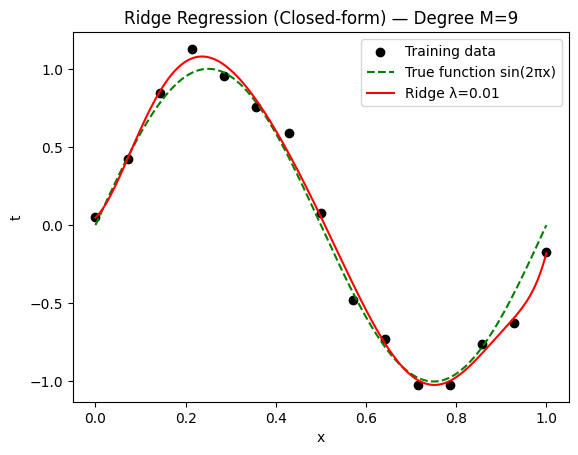

λ = 0.01
MSE (train): 0.0032
MSE (test) : 0.0056


In [ ]:
# %%
# ============================================================
# RIDGE REGRESSION — Closed-form implementation
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def fit_ridge(X, t, M, lam):
    """
    Stima i pesi w della Ridge Regression:
        w = (ΦᵀΦ + λI)⁻¹ Φᵀt
    Parametri:
        X   : input normalizzato (n×1)
        t   : target (n×1)
        M   : grado del polinomio
        lam : coefficiente di regolarizzazione λ
    Ritorna:
        w   : pesi stimati
        Φ   : matrice di design
    """
    # Costruzione della matrice di design
    Phi = polynomial_design_matrix(X, M)

    # Matrice identità per il termine λI
    I = np.eye(Phi.shape[1])

    # Soluzione chiusa della Ridge
    w = np.linalg.pinv(Phi.T @ Phi + lam * I) @ Phi.T @ t

    return w, Phi


# ------------------------------------------------------------
# 1️⃣  Esperimento con M = 9 (modello molto flessibile)
# ------------------------------------------------------------
M = 9
lam = 1e-2  # regolarizzazione moderata

# Fit del modello Ridge
w_ridge, Phi_train = fit_ridge(X_train_n, t_train, M, lam)

# Predizioni
y_ridge_train = predict(X_train_n, w_ridge)
y_ridge_test = predict(X_test_n, w_ridge)

# ------------------------------------------------------------
# 2️⃣  Confronto visivo
# ------------------------------------------------------------
plt.scatter(X_train, t_train, color="black", label="Training data")
plt.plot(X_test, t_test, "g--", label="True function sin(2πx)")
plt.plot(X_test, y_ridge_test, "r", label=f"Ridge λ={lam}")
plt.legend()
plt.title(f"Ridge Regression (Closed-form) — Degree M={M}")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


# ------------------------------------------------------------
# 3️⃣  Valutazione quantitativa
# ------------------------------------------------------------
mse_train = mean_squared_error(t_train, y_ridge_train)
mse_test = mean_squared_error(t_test, y_ridge_test)

print(f"λ = {lam}")
print(f"MSE (train): {mse_train:.4f}")
print(f"MSE (test) : {mse_test:.4f}")

## 🔍 Effetto della regolarizzazione λ in Ridge Regression

In questa sezione osserviamo come la **regolarizzazione L2** (controllata dal parametro λ)  
influenzi il comportamento del modello polinomiale.

- **λ = 0** → coincide con la regressione ai minimi quadrati: il modello segue perfettamente i dati (rischio di *overfitting*).  
- **λ moderato (10⁻³ – 10⁻¹)** → i pesi vengono “contenuti”, il modello è più liscio e generalizza meglio.  
- **λ grande (≥ 1)** → la penalità domina: la curva diventa quasi lineare (*underfitting*).

📈 In questo esperimento visualizziamo l’effetto di diversi valori di λ,  
mantenendo fisso il grado polinomiale $M=9$.

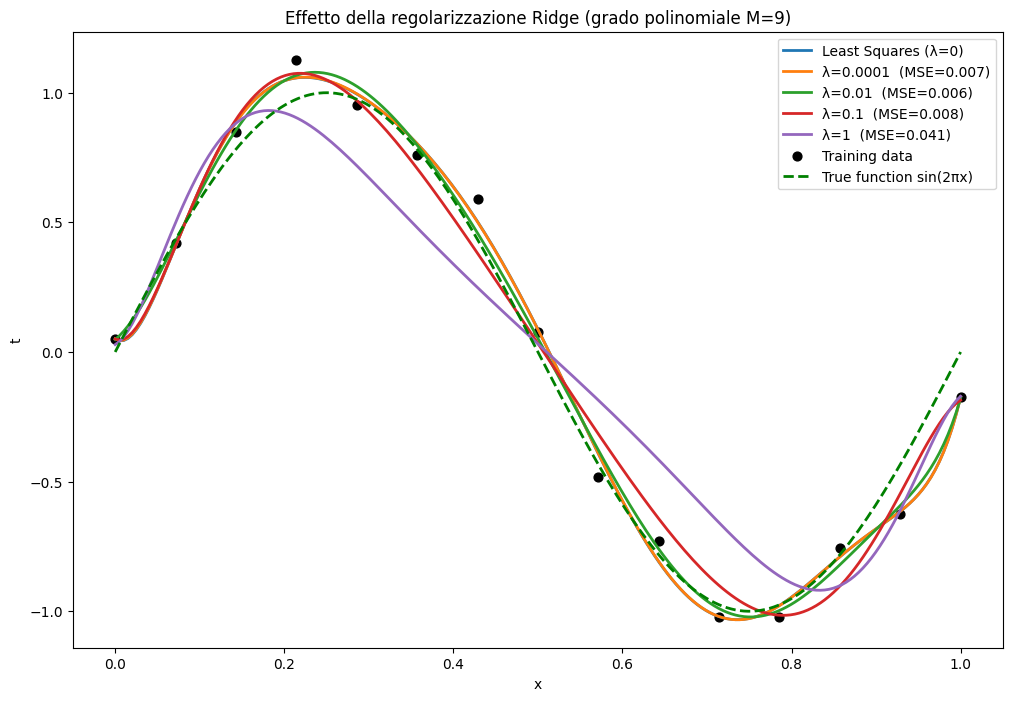

In [ ]:
# %%
# ============================================================
# RIDGE REGRESSION — Effetto della regolarizzazione λ
# ============================================================

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Parametri di esperimento
M = 9                         # grado polinomiale elevato → alto rischio di overfitting
lambdas = [0, 1e-4, 1e-2, 1e-1, 1]   # diversi livelli di regolarizzazione

plt.figure(figsize=(12, 8))

# ------------------------------------------------------------
# Ciclo sui diversi valori di λ
# ------------------------------------------------------------
for lam in lambdas:
    # Fit del modello Ridge (λ = 0 equivale ai minimi quadrati)
    w_ridge, Phi_train_ridge = fit_ridge(X_train_n, t_train, M, lam)
    y_ridge_test = predict(X_test_n, w_ridge)

    # Calcolo dell'errore sul test set
    mse_test = mean_squared_error(t_test, y_ridge_test)

    # Tracciamento della curva
    label = f"λ={lam}  (MSE={mse_test:.3f})" if lam > 0 else f"Least Squares (λ=0)"
    plt.plot(X_test, y_ridge_test, linewidth=2, label=label)

# ------------------------------------------------------------
# Dati e funzione vera
# ------------------------------------------------------------
plt.scatter(X_train, t_train, color="black", s=40, label="Training data")
plt.plot(X_test, t_test, "g--", linewidth=2, label="True function sin(2πx)")

plt.title(f"Effetto della regolarizzazione Ridge (grado polinomiale M={M})")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

## Ridge via Gradient Descent

## ⚙️ Ridge Regression — Gradient Descent Implementation (con Clipping)

In questa sezione implementiamo la **Ridge Regression** in forma **iterativa**,
utilizzando la **Discesa del Gradiente batch (Batch Gradient Descent)**,  
invece della classica soluzione chiusa dei minimi quadrati regolarizzati.

---

### 🔹 1️⃣ Funzione di costo regolarizzata

La funzione di costo Ridge combina due termini:

$$
E_\lambda(w) = \frac{1}{2n}\|\Phi w - t\|^2 + \frac{\lambda}{2}\|w\|^2
$$

- **Errore di ricostruzione**: misura quanto bene il modello approssima i dati  
- **Penalità L2**: riduce i pesi troppo grandi, controllando la complessità del modello  

La Ridge, infatti, tende a preferire soluzioni “piccole” ma stabili.

---

### 🔹 2️⃣ Discesa del gradiente batch

Il gradiente della funzione di costo è:

$$
\nabla_w E_\lambda(w) = \frac{1}{n}\Phi^\top(\Phi w - t) + \lambda w
$$

e l’aggiornamento dei pesi ad ogni iterazione è:

$$
w \leftarrow w - \eta \, \nabla_w E_\lambda(w)
$$

dove:
- $ \eta $ è il **learning rate**,  
- $ \lambda $ controlla la **forza della regolarizzazione**.  

Dopo un numero sufficiente di epoche, $w$ converge al valore ottimo che minimizza $E_\lambda(w)$ (equivalente alla soluzione chiusa della Ridge).

---

### 🔹 3️⃣ Clipping: perché lo usiamo

Nel codice, sia i **residui** $(\Phi w - t)$ sia i **gradienti** vengono “clipped” con la funzione `np.clip()` per **limitare i valori estremi**.

Questo serve a **prevenire instabilità numeriche**:

- nei modelli polinomiali, i valori di $\Phi$ possono crescere molto rapidamente (es. $x^9$, $x^{12}$…),  
- di conseguenza, il gradiente può assumere valori enormi, causando divergenza o overflow.

Il **gradient clipping** forza il gradiente (o i pesi) a rimanere entro un intervallo controllato:

$$
g_i \leftarrow \text{clip}(g_i, -c, +c)
$$

Questo è lo stesso principio usato nel **deep learning** per stabilizzare l’addestramento.

> 💡 In breve: il clipping non modifica il minimo teorico, ma evita che il processo di discesa “esploda” durante l’ottimizzazione.

---

### 🔹 4️⃣ Interpretazione dei risultati

- Il grafico del costo $E_\lambda(w)$ decresce gradualmente fino a stabilizzarsi → **convergenza**.  
- La curva appresa (linea rossa) è **più regolare** della regressione ai minimi quadrati puri:  
  la regolarizzazione $\lambda$ ha effettivamente ridotto l’overfitting.  
- All’aumentare di $\lambda$, i pesi si contraggono e la curva diventa più liscia.

---

### 🔹 5️⃣ Metrica di valutazione

Infine, confrontiamo il **Mean Squared Error (MSE)** su training e test set:

- MSE basso su entrambi → buon fit generalizzante  
- MSE basso su train ma alto su test → *overfitting*  
- MSE alto su entrambi → *underfitting*

---

### 💡 In sintesi

| Concetto | Formula | Effetto |
|-----------|----------|---------|
| Costo Ridge | $$E_\lambda(w) = \tfrac{1}{2n}\|\Phi w - t\|^2 + \tfrac{\lambda}{2}\|w\|^2$$ | Penalizza pesi grandi |
| Gradiente | $$\nabla_w E_\lambda(w) = \tfrac{1}{n}\Phi^\top(\Phi w - t) + \lambda w$$ | Direzione di discesa |
| Aggiornamento | $w \leftarrow w - \eta \nabla_w E_\lambda(w)$ | Passo iterativo verso il minimo |
| Clipping | `np.clip(g, -c, +c)` | Stabilizza l’ottimizzazione |
| Risultato | MSE più basso e curva più liscia | Migliore generalizzazione |

---

📈 **Osservazione finale:**  
Questa versione iterativa con clipping è concettualmente la stessa che si usa per allenare reti neurali —  
solo che qui la usiamo su un semplice modello di regressione lineare,  
rendendo evidente il legame tra **Ridge Regression** e **ottimizzazione numerica moderna**.

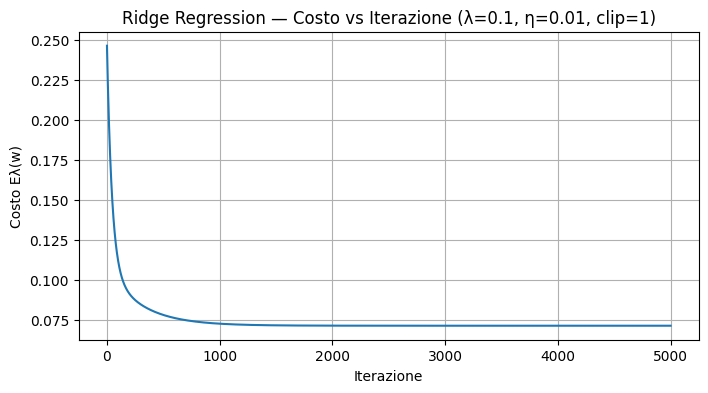

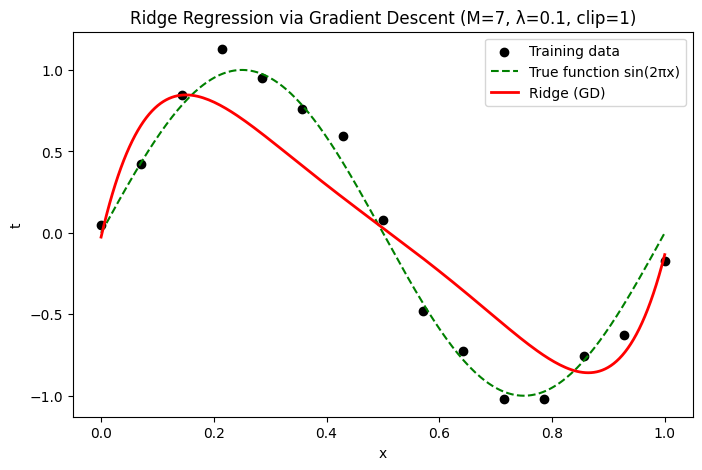

MSE train: 0.0745
MSE test : 0.0723


In [ ]:
# %%
# ============================================================
# RIDGE REGRESSION — Gradient Descent Implementation (con clipping)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------
# 1️⃣  Funzione di costo e gradiente
# ------------------------------------------------------------
def cost_ridge(Phi, w, t, lam):
    """
    Funzione di costo regolarizzata (Ridge):
        Eλ(w) = 1/(2n) * ||Φw - t||² + (λ/2) * ||w||²
    """
    r = Phi @ w - t
    mse_term = 0.5 * np.mean(r**2)
    reg_term = 0.5 * lam * np.sum(w**2)
    return mse_term + reg_term


def grad_ridge(Phi, w, t, lam):
    """
    Gradiente della funzione di costo Ridge:
        ∇Eλ(w) = (1/n) * Φᵀ(Φw - t) + λw
    """
    r = Phi @ w - t
    return (Phi.T @ r) / len(t) + lam * w


# ------------------------------------------------------------
# 2️⃣  Discesa del gradiente batch
# ------------------------------------------------------------
def gradient_descent_ridge(Phi, t, lam=1e-2, eta=1e-2, epochs=3000,
                           clip_grad=None, clip_w=None):
    """
    Discesa del gradiente per Ridge Regression.
    Include il clipping opzionale di gradienti e pesi.
    """
    w = np.zeros((Phi.shape[1], 1))
    costs = []

    for _ in range(epochs):
        # Gradiente Ridge
        g = grad_ridge(Phi, w, t, lam)

        # Gradient clipping (per stabilità numerica)
        if clip_grad is not None:
            g = np.clip(g, -clip_grad, clip_grad)

        # Aggiornamento dei pesi
        w -= eta * g

        # (Opzionale) Clipping dei pesi
        if clip_w is not None:
            w = np.clip(w, -clip_w, clip_w)

        # Calcolo del costo
        costs.append(cost_ridge(Phi, w, t, lam))

    return w, costs


# ------------------------------------------------------------
# 3️⃣  Esperimento: confronto visivo e andamento della loss
# ------------------------------------------------------------
M = 7         # grado polinomiale
lam = 0.1     # regolarizzazione
eta = 0.01    # learning rate
epochs = 5000 # numero di iterazioni
clip_grad = 1 # soglia di clipping del gradiente
clip_w = None # opzionale: clipping dei pesi

# Matrice di design
Phi_train = polynomial_design_matrix(X_train_n, M)

# Addestramento con discesa del gradiente Ridge
w_ridge_gd, costs = gradient_descent_ridge(Phi_train, t_train, lam, eta, epochs,
                                           clip_grad=clip_grad, clip_w=clip_w)

# Predizioni su train e test
y_ridge_train = predict(X_train_n, w_ridge_gd)
y_ridge_test  = predict(X_test_n, w_ridge_gd)

# ------------------------------------------------------------
# 4️⃣  Grafico della funzione di costo
# ------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(costs)
plt.title(f"Ridge Regression — Costo vs Iterazione (λ={lam}, η={eta}, clip={clip_grad})")
plt.xlabel("Iterazione")
plt.ylabel("Costo Eλ(w)")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 5️⃣  Confronto visivo del fit
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(X_train, t_train, color="black", label="Training data")
plt.plot(X_test, t_test, "g--", label="True function sin(2πx)")
plt.plot(X_test, y_ridge_test, "r", linewidth=2, label="Ridge (GD)")
plt.legend()
plt.title(f"Ridge Regression via Gradient Descent (M={M}, λ={lam}, clip={clip_grad})")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

# ------------------------------------------------------------
# 6️⃣  Valutazione numerica
# ------------------------------------------------------------
mse_train = mean_squared_error(t_train, y_ridge_train)
mse_test  = mean_squared_error(t_test, y_ridge_test)
print(f"MSE train: {mse_train:.4f}")
print(f"MSE test : {mse_test:.4f}")

## 🧰 Regressione lineare con *scikit-learn*

Finora abbiamo derivato e implementato a mano:
- la **regressione ai minimi quadrati**,  
- la **Ridge Regression** (regolarizzazione L2),  
- e la **Lasso Regression** (regolarizzazione L1).

Tutti questi modelli sono disponibili direttamente nella libreria **`scikit-learn`**,  
che fornisce implementazioni ottimizzate e numericamente stabili.

Vediamo come usare:
- `LinearRegression` → minimi quadrati standard,  
- `Ridge` → regressione L2,  
- `Lasso` → regressione L1.

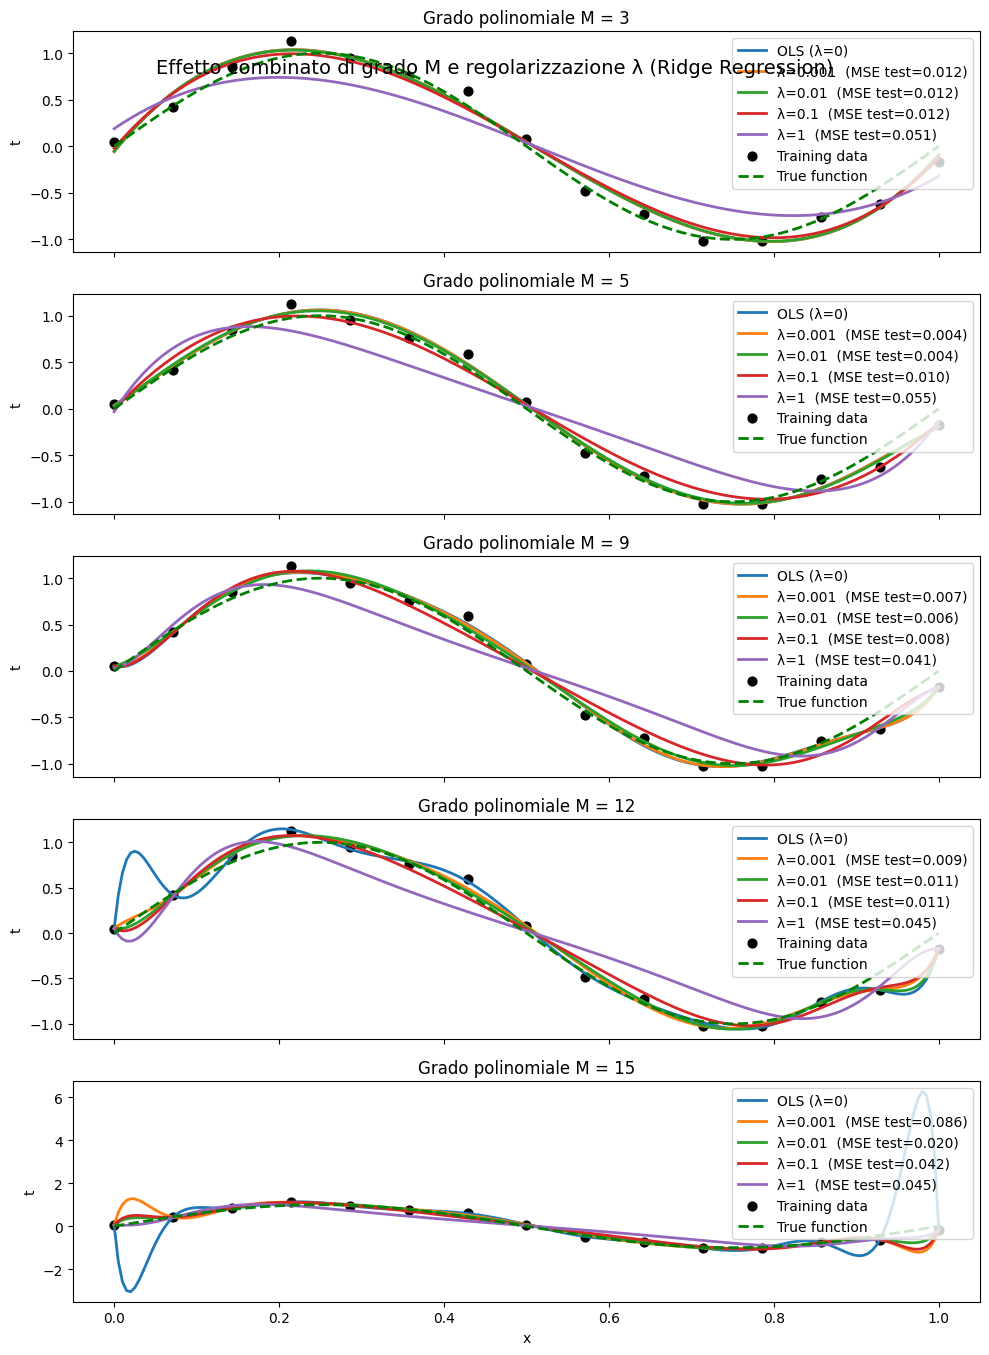

=== Mean Squared Error (MSE) ===

Grado polinomiale M = 3
λ		Train MSE	Test MSE
----------------------------------------
0       	0.0112		0.0120
0.001   	0.0112		0.0120
0.01    	0.0112		0.0119
0.1     	0.0121		0.0122
1       	0.0576		0.0508

Grado polinomiale M = 5
λ		Train MSE	Test MSE
----------------------------------------
0       	0.0042		0.0038
0.001   	0.0042		0.0039
0.01    	0.0043		0.0040
0.1     	0.0100		0.0098
1       	0.0564		0.0545

Grado polinomiale M = 9
λ		Train MSE	Test MSE
----------------------------------------
0       	0.0024		0.0075
0.001   	0.0025		0.0071
0.01    	0.0032		0.0056
0.1     	0.0088		0.0081
1       	0.0447		0.0409

Grado polinomiale M = 12
λ		Train MSE	Test MSE
----------------------------------------
0       	0.0005		0.0339
0.001   	0.0021		0.0091
0.01    	0.0028		0.0112
0.1     	0.0065		0.0113
1       	0.0462		0.0452

Grado polinomiale M = 15
λ		Train MSE	Test MSE
----------------------------------------
0       	0.0000		1.5126
0.001   	0.0013		0.08

In [ ]:
# %%
# ============================================================
# RIDGE REGRESSION — Effetto combinato di grado M e regolarizzazione λ
# ============================================================

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Gradi polinomiali da esplorare
degrees = [3, 5, 9, 12, 15]
# Diversi valori di regolarizzazione
lambdas = [0, 1e-3, 1e-2, 1e-1, 1]

# Creazione dei subplot (una riga per ogni M)
fig, axes = plt.subplots(len(degrees), 1, figsize=(10, 14), sharex=True)

# Dizionario per salvare i risultati numerici
mse_results = {}

for i, M in enumerate(degrees):
    ax = axes[i]
    Phi_train = polynomial_design_matrix(X_train_n, M)
    Phi_test = polynomial_design_matrix(X_test_n, M)
    mse_results[M] = {}

    for lam in lambdas:
        # Addestra il modello Ridge
        ridge = Ridge(alpha=lam, fit_intercept=False)
        ridge.fit(Phi_train, t_train)

        # Predizioni
        y_train_pred = ridge.predict(Phi_train)
        y_test_pred = ridge.predict(Phi_test)

        # Calcolo MSE su train e test
        mse_train = mean_squared_error(t_train, y_train_pred)
        mse_test = mean_squared_error(t_test, y_test_pred)

        mse_results[M][lam] = (mse_train, mse_test)

        # Traccia le curve
        label = f"λ={lam}  (MSE test={mse_test:.3f})" if lam > 0 else "OLS (λ=0)"
        ax.plot(X_test, y_test_pred, linewidth=2, label=label)

    # Dati e funzione vera
    ax.scatter(X_train, t_train, color="black", s=40, label="Training data")
    ax.plot(X_test, t_test, "g--", linewidth=2, label="True function")

    ax.set_title(f"Grado polinomiale M = {M}")
    ax.set_ylabel("t")
    ax.legend()

plt.xlabel("x")
plt.suptitle("Effetto combinato di grado M e regolarizzazione λ (Ridge Regression)", fontsize=14, y=0.93)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Stampa tabellare dei MSE per ogni combinazione (M, λ)
# ------------------------------------------------------------
print("=== Mean Squared Error (MSE) ===")
for M in degrees:
    print(f"\nGrado polinomiale M = {M}")
    print("λ\t\tTrain MSE\tTest MSE")
    print("-"*40)
    for lam, (mse_train, mse_test) in mse_results[M].items():
        print(f"{lam:<8g}\t{mse_train:.4f}\t\t{mse_test:.4f}")

### 📊 Analisi dei risultati — Effetto combinato di $M$ e $\lambda$

La tabella del **Mean Squared Error (MSE)** mostra come il comportamento del modello cambi al variare di:

- **$M$** → complessità del polinomio  
- **$\lambda$** → forza della regolarizzazione Ridge  

---

#### 🔹 Gradi bassi (M = 3, 5)
- Modelli semplici → errori simili su train e test.  
- La regolarizzazione incide poco: i pesi sono già piccoli.  
- Buona generalizzazione, MSE stabile intorno a 0.01.  
📘 Qui la Ridge è inutile: il modello non è complesso.

---

#### 🔹 Grado medio (M = 9)
- Senza regolarizzazione: **overfitting** (train 0.0024, test 0.0075).  
- Con $\lambda$ piccolo ($10^{-3}$–$10^{-2}$): test MSE scende a ~0.005.  
- Con $\lambda$ alto: cresce il bias.  
📘 Ridge efficace — bilancia complessità e stabilità.

---

#### 🔹 Grado alto (M = 12)
- Senza regolarizzazione: perfetto su train (0.0005), pessimo su test (0.03).  
- Con $\lambda$ piccolo: test MSE migliora (~0.01).  
📘 Leggera regolarizzazione = drastico miglioramento → riduce il rumore appreso.

---

#### 🔹 Grado molto alto (M = 15)
- $\lambda=0$: test MSE esplode (1.5) → segue il rumore.  
- $\lambda=0.001$–$0.01$: test MSE < 0.1 → ottima correzione.  
- $\lambda≥0.1$: curva troppo rigida → underfitting.  
📘 Con modelli molto flessibili, Ridge è indispensabile.

---

### 💡 Sintesi

| Modello | M | λ ideale | Effetto |
|----------|---|-----------|----------|
| Semplice | 3–5 | irrilevante | già stabile |
| Medio | 9 | 0.001–0.01 | riduce overfitting |
| Complesso | 12–15 | 0.001–0.01 | stabilizza e generalizza |

📈 Aumentare $M$ → più flessibilità ma più varianza.  
📉 Aumentare $\lambda$ → più controllo ma più bias.  
Il miglior punto è dove il **MSE di test è minimo**: equilibrio tra adattamento e regolarizzazione.